# Training the RNNO with rigid phases (PRISM SS2023)
In this notebook, we define a custom hinge joint, which is configured to generate pauses (no movement) inside the generated data series. We use this joint to train the RNNO and perfrom inference with the generated parameters.

In [2]:
import x_xy
import jax
import jax.numpy as jnp
import jax.random as random
from x_xy.subpkgs.ml import rnno, callbacks, train, load
import tree_utils
import matplotlib.pyplot as plt

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Defining the System
A system is defined in an XML structure. To read a system, an XML file may be used. It is also possible to define the system inline by using a string in XML-syntax.<br>In the following, we define two three-segment kinematic chains:

In [3]:
three_seg_rigid = r"""
<x_xy model="three_seg_rigid">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="free">
            <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" color="red"/>
            <body name="seg1" joint="rsry" pos="0 0 0">
                <geom type="box" mass="10" pos="-0.1 0 0" dim="0.2 0.05 0.05" color="yellow"/>
                <body name="imu1" pos="-0.1 0.0 0.03" joint="frozen">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" color="green"/>
                </body>
            </body>
            <body name="seg3" joint="rsrz" pos="0.2 0 0">
                <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05" color="blue"/>
                <body name="imu2" joint="frozen" pos="0.1 0.0 0.03">
                    <geom type="box" mass="2" pos="0 0 0" dim="0.05 0.01 0.01" color="green"/>
                </body>
            </body>
        </body>
    </worldbody>
    <defaults>
        <geom edge_color="black" color="1 0.8 0.7 1"/>
    </defaults>
</x_xy>
"""

In [4]:
dustin_exp_xml_seg1 = r"""
<x_xy model="dustin_exp">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg1" joint="free">
            <geom type="box" mass="10" pos="-0.1 0 0" dim="0.2 0.05 0.05"/>
            <body name="seg2" joint="ry">
                <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05"/>
                    <body name="seg3" joint="rz" pos="0.2 0 0" >
                        <geom type="box" mass="10" pos="0.1 0 0" dim="0.2 0.05 0.05"/>
                    </body>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

# Registering the joint axis
For this scenario, we define two systems: One for generating data with rigid phases and one for inference.<br>
To generate the random data with rigid phases, we first have to register a joint type, that allows for the creation of such data.<br>
We call this joint 'rsr\<x|y|z\>', a hinge joint that produces **r**andom **s**ometimes **r**igid data, and turns around the respective axis $x$, $y$ or $z$ in its frame.

## Generating random data
The random data is generated by the following functions:

In [5]:
# Helper function - Creates an array of values x <- [0, 1] which may be multiplied to another sequence.
def motion_amplifier(
        time : float,
        sampling_rate : float,
        key_rigid_phases : jax.Array,
        n_rigid_phases=3,
        rigid_duration_cov=jnp.array([0.02] * 3),
        transition_cov=jnp.array([0.1] * 3)
) -> jax.Array:
    error_msg = "motion_amplifier: There must be a variance for each rigid phase!"
    assert rigid_duration_cov.shape == (n_rigid_phases,) == transition_cov.shape, error_msg
    n_frames = int(time / sampling_rate)
    key_rigid_means, key_rigid_variances, key_slope_down_variances, key_slope_up_variances = random.split(key_rigid_phases, 4)

    # Calculate center points of rigid phases
    means = jnp.sort(random.uniform(key_rigid_means, shape=(n_rigid_phases, 1), minval=0, maxval=n_frames).T)

    # Calculate durations, which is twice the rigid distance from the center points for each rigid phase.
    rigid_distances = jnp.abs(random.multivariate_normal(
        key_rigid_variances, mean=jnp.zeros_like(means), cov=jnp.diag((rigid_duration_cov * n_frames)**2)))

    # Calculate transition durations
    transition_slowdown_durations = jnp.abs(random.multivariate_normal(
        key_slope_down_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)
        ))
    transition_speedup_durations = jnp.abs(random.multivariate_normal(
        key_slope_up_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)
        ))

    # Phase start and end points
    rigid_starts = (means - rigid_distances).astype(int).flatten()
    rigid_ends = (means + rigid_distances).astype(int).flatten()
    starts_slowing = (means - rigid_distances - transition_slowdown_durations).astype(int).flatten()
    ends_moving = (means + rigid_distances + transition_speedup_durations).astype(int).flatten()

    # Create masks
    def create_mask(start, end):
        nonlocal n_frames
        return jnp.where(jnp.arange(n_frames) < start, 1, 0) + jnp.where(jnp.arange(n_frames) >= end, 1, 0)

    mask = jax.vmap(create_mask)
    rigid_mask = jnp.prod(mask(rigid_starts, rigid_ends), axis=0)
    slowdown_masks = mask(starts_slowing, rigid_starts).astype(float)
    speedup_masks = mask(rigid_ends, ends_moving).astype(float)

    # We have to define an inline function in order to make this code JIT-able
    def linsp(mask, start, end, begin_val, carry_fun):
        range = end - start
        def true_fun(carry, x): return (carry_fun(carry, range), 1 - carry)
        def false_fun(carry, x): return (carry, x)
        def f(carry, x): return jax.lax.cond(
            x == 0, true_fun, false_fun, *(carry, x))
        return jax.lax.scan(f, begin_val, mask)[1]

    linsp_desc = jax.vmap(lambda m, s1, s2: linsp( m, s1, s2, 0.0, lambda carry, range: carry + 1/range))
    slowdown_mask = jnp.prod(linsp_desc(slowdown_masks, starts_slowing, rigid_starts), axis=0)

    linsp_asc = jax.vmap(lambda m, s1, s2: linsp(m, s1, s2, 1.0, lambda carry, range: carry - 1/range))
    speedup_mask = jnp.prod(linsp_asc(speedup_masks, rigid_ends, ends_moving), axis=0)

    return jnp.min(jnp.stack([rigid_mask, slowdown_mask, speedup_mask]), axis=0)

In [6]:
# Random generator: Uses the motion_amplifier to dampen/null the randomly generated angles.
def random_angles_with_rigid_phases_over_time(
    key_t,
    key_ang,
    key_rigid_phases,
    n_rigid_phases=3,
    rigid_duration_cov=jnp.array([0.02] * 3),
    transition_cov=jnp.array([0.1] * 3),
    config: x_xy.algorithms.RCMG_Config=x_xy.algorithms.RCMG_Config()
) -> jax.Array:

    mask = motion_amplifier(
        config.T,
        config.Ts,
        key_rigid_phases,
        n_rigid_phases,
        rigid_duration_cov,
        transition_cov)
    
    qs = x_xy.algorithms.random_angle_over_time(
        key_t=key_t,
        key_ang=key_ang,
        ANG_0=config.ang0_max,
        dang_min=config.dang_min,
        dang_max=config.dang_max,
        delta_ang_min=config.delta_ang_min,
        delta_ang_max=config.delta_ang_max,
        t_min=config.t_min,
        t_max=config.t_max,
        T=config.T,
        Ts=config.Ts,
        randomized_interpolation=config.randomized_interpolation_angle,
        range_of_motion=config.range_of_motion_hinge,
        range_of_motion_method=config.range_of_motion_hinge_method
    )

    # derivate qs
    qs_diff = jnp.diff(qs, axis=0)

    # mulitply with motion amplifier
    qs_diff = qs_diff * mask[:-1]

    # integrate qs_diff
    qs_rigid_phases = jnp.concatenate((qs[0:1], jnp.cumsum(qs_diff, axis=0)))
    return qs_rigid_phases

## Defining the random joint function
First of all, we have to define our problem. This means, parameterzing the random function.<br>
Two possible scenarios are implemented below: "BEST_RUN" and "MANY_TINY_STOPS", both of which achieved adequate results.<br>
The problems are defined as $P=(N, \mathbf{\sigma}_{r}, \mathbf{\sigma}_{tr})$, with $N$ being the number of rigid phases, $\mathbf{\sigma}_r$ the covariance used for calculating the length of each rigid phase and $\mathbf{\sigma}_{tr}$ for the length of each transition phase respectively. It also holds that $\mathbf{\sigma}_r, \mathbf{\sigma}_{tr} \in \mathbb{R}^N$, with each entry being the variance for exactly one rigid phase.

In [7]:
BEST_RUN = (1, jnp.array([0.02]), jnp.array([0.1]))
MANY_TINY_STOPS = (30, jnp.array([0.001] * 30), jnp.array([0.0001] * 30))
##################################################################################
# Define your own problem configuration here :)                                  #

PROBLEM = BEST_RUN # <- Change this assignment to use it.
##################################################################################

def define_joints():
    def _draw_sometimes_rigid(
            config: x_xy.algorithms.RCMG_Config, key_t: jax.Array, key_value: jax.Array, _ : jax.Array
    ) -> jax.Array:
        key_t, key_rigid_phases = jax.random.split(key_t)
        return random_angles_with_rigid_phases_over_time(
            key_t=key_t,
            key_ang=key_value,
            key_rigid_phases=key_rigid_phases,
            n_rigid_phases=PROBLEM[0],
            rigid_duration_cov=PROBLEM[1],
            transition_cov=PROBLEM[2],
            config=config
        )

    def _rxyz_transform(q, _, axis):
        q = jnp.squeeze(q)
        rot = x_xy.maths.quat_rot_axis(axis, q)
        return x_xy.base.Transform.create(rot=rot)

    rsrx_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([1.0, 0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsry_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 1.0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    rsrz_joint = x_xy.algorithms.JointModel(
        lambda q, _: _rxyz_transform(q, _, jnp.array([0, 0, 1.0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
    )
    try:
        x_xy.algorithms.register_new_joint_type("rsrx", rsrx_joint, 1)
        x_xy.algorithms.register_new_joint_type("rsry", rsry_joint, 1)
        x_xy.algorithms.register_new_joint_type("rsrz", rsrz_joint, 1)
    except AssertionError:
        print("Warning: Joints have already been registered!")
        
define_joints()

Note: it is also possible to support multiple problems at the same time, by implementing them as seperate joint types, or by injecting the `x_xy.algorithms.RCMG_Config` class e.g. by inheritance.

After we defined the joint type, we can load the system:

In [8]:
sys_rigid = x_xy.io.load_sys_from_str(three_seg_rigid)
sys_inference = x_xy.io.load_sys_from_str(dustin_exp_xml_seg1)

# Generating raw data
For both training and inference, we first need a set of raw data. In our example, `sys_rigid` is used to generate the problem-specific data for each IMU. This data will be used for training and later by `sys_inference` to estimate the position and orientation of `seg2`, which has no IMU attached.

In [9]:
def finalize_fn_imu_data(key, q, x, sys):
    imu_seg_attachment = {"imu1": "seg1", "imu2": "seg3"}

    X = {}
    for imu, seg in imu_seg_attachment.items():
        key, consume = jax.random.split(key)
        X[seg] = x_xy.algorithms.imu(
            x.take(sys.name_to_idx(imu), 1), sys.gravity, sys.dt, consume, True
        )
    return X


def finalize_fn_rel_pose_data(key, _, x, sys):
    y = x_xy.algorithms.rel_pose(sys_scan=sys_inference, xs=x, sys_xs=sys)
    return y

def finalize_fn(key, q, x, sys):
    X = finalize_fn_imu_data(key, q, x, sys)
    # Since no IMU is attached to seg2, we need to provide dummy data.
    X["seg2"] = tree_utils.tree_zeros_like(X["seg1"])
    y = finalize_fn_rel_pose_data(key, q, x, sys)
    return X, y

The generated data comes is returned in the tuple $(\mathbf{X}, \mathbf{y})$, with $\mathbf{X}$ being the generated IMU accelorometer and gyroscope data and $\mathbf{y}$ the orientation of each segment, in form of a unit quaternion.<br>

# Train the model
Before we begin with the actual training, we first define a setup function. This is called before training on each time series.<br>
The function below alters the length of segments and the position of the IMUs of the system, to simulate inaccuracies, e.g. when dealing  with experimental data.

In [10]:
def setup_fn_seg2(key, sys: x_xy.base.System) -> x_xy.base.System:
    def replace_pos(transforms, new_pos, name: str):
        i = sys.name_to_idx(name)
        return transforms.index_set(i, transforms[i].replace(pos=new_pos))
    
    def draw_pos_uniform(key, pos_min, pos_max):
        key, c1, c2, c3 = jax.random.split(key, num=4)
        pos = jnp.array(
            [
                jax.random.uniform(c1, minval=pos_min[0], maxval=pos_max[0]),
                jax.random.uniform(c2, minval=pos_min[1], maxval=pos_max[1]),
                jax.random.uniform(c3, minval=pos_min[2], maxval=pos_max[2]),
            ]
        )
        return key, pos

    ts = sys.links.transform1

    # seg1 relative to seg2
    key, pos = draw_pos_uniform(key, [-0.3, -0.02, -0.02], [-0.05, 0.02, 0.02])
    ts = replace_pos(ts, pos, "seg1")

    # imu1 relative to seg1
    key, pos = draw_pos_uniform(
        key, [-0.25, -0.05, -0.05], [-0.05, 0.05, 0.05])
    ts = replace_pos(ts, pos, "imu1")

    # seg3 relative to seg2
    key, pos = draw_pos_uniform(key, [0.05, -0.02, -0.02], [0.3, 0.02, 0.02])
    ts = replace_pos(ts, pos, "seg3")

    # imu2 relative to seg2
    key, pos = draw_pos_uniform(key, [0.05, -0.05, -0.05], [0.25, 0.05, 0.05])
    ts = replace_pos(ts, pos, "imu2")

    return sys.replace(links=sys.links.replace(transform1=ts))

With this, we can now train the model:<br>
We first define the batch size and number of epochs. For good results, a relatively large number of epochs is required, as the mean average angle error in training converges relatively late in training.<br>
Then we plug together the setup- and finalize functions in a generator function, which will provide the batched training data.<br>
A logger might also be added, such as a neptune logger. When using neptune, the environment-variables `NEPTUNE_TOKEN` and `NEPTUNE_PROJECT` must be set accordingly. 

In [11]:
TRAINING_BATCH_SIZE = 80
EPOCHS = 1500
params_path = "parameters.pickle"
KEY_GEN = random.PRNGKey(1)
KEY_NETWORK = random.PRNGKey(1)

gen = x_xy.algorithms.build_generator(sys_rigid, x_xy.algorithms.RCMG_Config(), setup_fn_seg2, finalize_fn)
gen = x_xy.algorithms.batch_generator(gen, TRAINING_BATCH_SIZE)

# Set 'upload' to True if a logger is attached.
save_params = callbacks.SaveParamsTrainingLoopCallback(params_path, upload=False) 

loggers = []
# loggers.append(NeptuneLogger()) # You may add loggers here, e.g. a Neptune Logger

network = rnno.make_rnno(sys_inference)

**WARNING!**<br>
Executing this code can take a long time (due to the very high number of epochs) and will probably take up a huge portion of your memory.<br>
If you run this code on a GPU, a batch size of 80 takes more than 50 GB of VRAM, so if the execution fails, it might be because of missing GPU memory. To circumvent this, the batch size can be decreased, however, the results will suffer from that.

In [12]:
train(gen, EPOCHS, network, loggers=loggers, callbacks=[save_params], key_generator=KEY_GEN, key_network=KEY_NETWORK)

# Infering data

In [12]:
def finalize_fn_inference(key, q, x, sys):
    X = finalize_fn_imu_data(key, q, x, sys)
    y = finalize_fn_rel_pose_data(key, q, x, sys)
    return X, y, x


def generate_inference_data(sys, config: x_xy.algorithms.RCMG_Config, seed=random.PRNGKey(1,)):
    generator = x_xy.algorithms.build_generator(sys, config, finalize_fn=finalize_fn_inference)
    X, y, xs = generator(seed)
    return X, y, xs

To control the data generated, the RCMG_Config data is used. It contains all necessary information about the to-be-generated data series, e.g. time (`config.T`), sampling rate (`config.Ts`).<br>
The finalize function and its return values are similiar to the training finilaize function, however, an addtitional $\mathbf{xs}$ is returned, containing the actual position and rotation. This can be used for rendering purposes later. Also, the data is not batched, as we currently are only interested in one time series.

In [13]:
config = x_xy.algorithms.RCMG_Config()
print(f"Generating data for a time series of {config.T} seconds, with a sampling rate of {1/config.Ts} Hz.")

# If you are unhappy with your data series, you can alter this seed:
seed = random.PRNGKey(1337,)

X, y, xs = generate_inference_data(sys_rigid, config, seed)

# Add dummy IMU data for segment 2 (which has no IMU attached)
X["seg2"] = tree_utils.tree_zeros_like(X["seg1"])

Generating data for a time series of 60.0 seconds, with a sampling rate of 100.0 Hz.


# Inference
To do inference, we first need to load the parameters (weights) of our model.

In [16]:
params = load("parameters.pickle")

Finally, we have everything we need to do inference! Let's see how our network performs...

seg2: medium absolute error 0.524849534034729 deg
seg3: medium absolute error 0.5137953162193298 deg


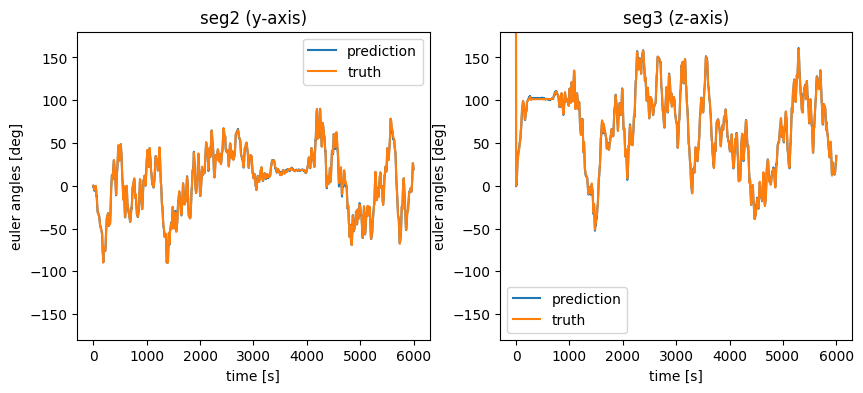

In [17]:
# Run prediction:
X_3d = tree_utils.to_3d_if_2d(X, strict=True)
initial_params, state = network.init(random.PRNGKey(1,), X_3d)
yhat, _ = network.apply(params, tree_utils.add_batch_dim(state), X_3d)
yhat = tree_utils.to_2d_if_3d(yhat, strict=True)

# Plot prediction:
def plot_segment(segment : str, axis : str, ax):
    axis_idx = "xyz".index(axis)
    euler_angles_hat_seg2 = jnp.rad2deg(x_xy.maths.quat_to_euler(yhat[segment])[:,axis_idx])
    euler_angles_seg2 = jnp.rad2deg(x_xy.maths.quat_to_euler(y[segment])[:,axis_idx])
    ax.plot(euler_angles_hat_seg2, label="prediction")
    ax.set_ylim((-180, 180))
    ax.set_title(f"{segment} ({axis}-axis)")
    ax.plot(euler_angles_seg2, label="truth")
    ax.set_xlabel("time [s]")
    ax.set_ylabel("euler angles [deg]")
    ax.legend()
    print(f"{segment}: medium absolute error {jnp.average(jnp.abs(euler_angles_hat_seg2 - euler_angles_seg2))} deg")

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
plot_segment("seg2", 'y', axs[0])
plot_segment("seg3", 'z', axs[1])
plt.show()